# End to end examples

## Crabs with XGBoost

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/EX-crabs-xgb"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\EX-crabs-xgb`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing D:\JULIA\6_ML_with_Julia\EX-crabs-xgb\Manifest.toml:0


> First steps
> XGBoost machine
> 1. More tuning (1)
> 2. More tuning (2)
> 3. More tuning (3)

### First steps

---

Again, the crabs dataset is so common that there is a simple load function for it:

In [2]:
using MLJ
using StatsBase
using Random
using PyPlot
using CategoricalArrays
using PrettyPrinting
import DataFrames

X , y = @load_crabs
X = DataFrames.DataFrame(X)

@show size(X)
@show y[1:3]
first(X, 3) |> pretty

size(X) = (200, 5)
y[1:3] = CategoricalValue{String, UInt32}["B", "B", "B"]
┌────────────┬────────────┬────────────┬────────────┬────────────┐
│ FL         │ RW         │ CL         │ CW         │ BD         │
│ Float64    │ Float64    │ Float64    │ Float64    │ Float64    │
│ Continuous │ Continuous │ Continuous │ Continuous │ Continuous │
├────────────┼────────────┼────────────┼────────────┼────────────┤
│ 8.1        │ 6.7        │ 16.1       │ 19.0       │ 7.0        │
│ 8.8        │ 7.7        │ 18.1       │ 20.8       │ 7.4        │
│ 9.2        │ 7.8        │ 19.0       │ 22.4       │ 7.7        │
└────────────┴────────────┴────────────┴────────────┴────────────┘


It's a classification problem with the following classes:

In [3]:
levels(y) |> pprint

["B", "O"]

Note that the dataset is currently sorted by target, let's shuffle it to avoid the obvious issues this may cause

In [4]:
Random.seed!(523)
perm = randperm(length(y))
X = X[perm, : ]
y = y[perm];

In [5]:
train, test = partition(collect(eachindex(y)), 0.70, shuffle= true, rng = 52)
XGBC = @load XGBoostClassifier
xgb_model = XGBC()

import MLJXGBoostInterface

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔


XGBoostClassifier(
    num_round = 100,
    booster = "gbtree",
    disable_default_eval_metric = 0,
    eta = 0.3,
    gamma = 0.0,
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    subsample = 1.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    lambda = 1.0,
    alpha = 0.0,
    tree_method = "auto",
    sketch_eps = 0.03,
    scale_pos_weight = 1.0,
    updater = "auto",
    refresh_leaf = 1,
    process_type = "default",
    grow_policy = "depthwise",
    max_leaves = 0,
    max_bin = 256,
    predictor = "cpu_predictor",
    sample_type = "uniform",
    normalize_type = "tree",
    rate_drop = 0.0,
    one_drop = 0,
    skip_drop = 0.0,
    feature_selector = "cyclic",
    top_k = 0,
    tweedie_variance_power = 1.5,
    objective = "automatic",
    base_score = 0.5,
    eval_metric = "mlogloss",
    seed = 0,
    nthread = 1)

Let's check whether the training and is balanced, `StatsBase.countmap` is useful for that:

In [6]:
countmap(y[train]) |> pprint

Dict(CategoricalValue{String, UInt32} "B" => 62,
     CategoricalValue{String, UInt32} "O" => 78)

which is pretty balanced. You could check the same on the test set and full set and the same comment would still hold.

### XGBoost machine

---

Wrap a machine around an XGBoost model (XGB) and the data:

In [7]:
xgb = XGBC()
xgbm = machine(xgb, X, y)

Machine{XGBoostClassifier,…} trained 0 times; caches data
  model: MLJXGBoostInterface.XGBoostClassifier
  args: 
    1:	Source @723 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @732 ⏎ `AbstractVector{Multiclass{2}}`


We will tune it varying the number of rounds used and generate a learning curve

In [8]:
r = range(xgb, :num_round, lower = 50, upper = 500)
curve = learning_curve(xgbm, range = r, resolution = 50, measure = L1HingeLoss())

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 50 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 50 metamodels: 100%[=========================] Time: 0:00:07


(parameter_name = "num_round",
 parameter_scale = :linear,
 parameter_values = [50, 59, 68, 78, 87, 96, 105, 114, 123, 133  …  417, 427, 436, 445, 454, 463, 472, 482, 491, 500],
 measurements = [0.24836397171020508, 0.24545636773109436, 0.24268636107444763, 0.2397555410861969, 0.23826450109481812, 0.2352793961763382, 0.23448707163333893, 0.23310495913028717, 0.2308061718940735, 0.22965149581432343  …  0.21469055116176605, 0.21440592408180237, 0.21408171951770782, 0.2139209806919098, 0.213658407330513, 0.2135016769170761, 0.2134832739830017, 0.21321788430213928, 0.21296538412570953, 0.21279016137123108],)

Let's have a look

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


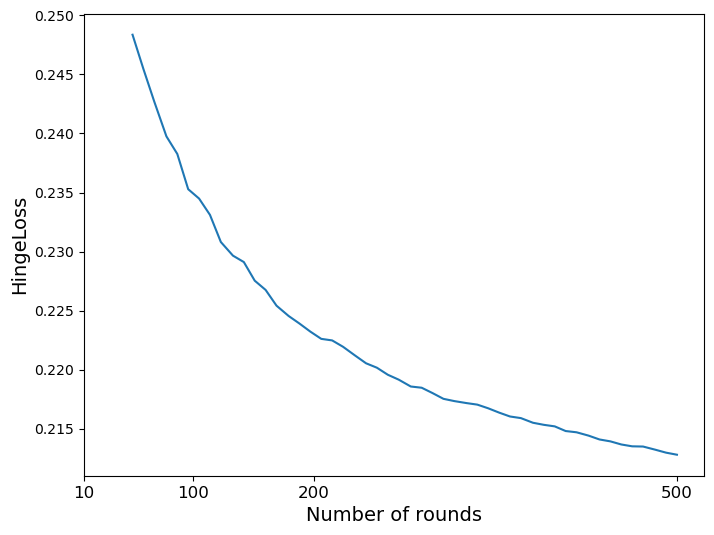

In [9]:
figure(figsize = (8, 6))
plot(curve.parameter_values, curve.measurements)
xlabel("Number of rounds", fontsize = 14)
ylabel("HingeLoss", fontsize = 14)
xticks([10, 100, 200, 500], fontsize = 12)
savefig("./plots/4.4.0.png")

So, in short, using more rounds helps. Let's arbitrarily fix it to 200.

```Julia
xgb.num_round = 200;
```

### More tuning (1)

Let's now tune the maximum depth of each tree and the minimum child weight in the boosting.

In [10]:
r1 = range(xgb, :max_depth, lower = 3, upper = 10)
r2 = range(xgb, :min_child_weight, lower = 0, upper = 5)

tm = TunedModel(model = xgb, 
                tuning = Grid(resolution = 8),
                resampling=CV(rng=11),
                ranges = [r1, r2],
                measure = cross_entropy)
mtm = machine(tm, X, y)
fit!(mtm, rows = train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 64 metamodels: 100%[=========================] Time: 0:00:06


Machine{ProbabilisticTunedModel{Grid,…},…} trained 1 time; caches data
  model: MLJTuning.ProbabilisticTunedModel{Grid, MLJXGBoostInterface.XGBoostClassifier}
  args: 
    1:	Source @995 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @023 ⏎ `AbstractVector{Multiclass{2}}`


Great, as always we can investigate the tuning by using `report` and can, for instance, plot a heatmap of the measurements:

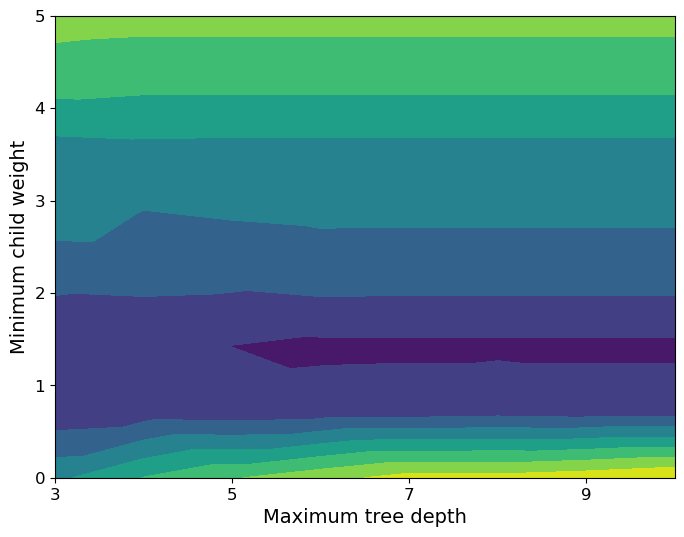

In [11]:
r = report(mtm)

res = r.plotting

md = res.parameter_values[:, 1]
mcw = res.parameter_values[:, 2]

figure(figsize=(8,6))
tricontourf(md, mcw, res.measurements)

xlabel("Maximum tree depth", fontsize = 14)
ylabel("Minimum child weight", fontsize = 14)
xticks(3:2:10, fontsize = 12)
yticks(fontsize = 12)
savefig("./plots/4.4.1.png")

Let's extract the optimal model and inspect its parameters:

In [12]:
xgb = fitted_params(mtm).best_model
@show xgb.max_depth
@show xgb.min_child_weight

xgb.max_depth = 6
xgb.min_child_weight = 1.4285714285714286


1.4285714285714286

### More tuning (2)

Let's examine the effect of `gamma`:

In [13]:
xgbm = machine(xgb, X, y)
r = range(xgb, :gamma, lower = 0, upper = 10)
curve = learning_curve!(xgbm, 
                        range = r, 
                        resolution =30,
                        measure=cross_entropy);

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:00


it looks like the `gamma` parameter substantially affects model performance:

In [14]:
@show round(minimum(curve.measurements), sigdigits = 3)
@show round(maximum(curve.measurements), sigdigits = 3)

round(minimum(curve.measurements), sigdigits = 3) = 0.231
round(maximum(curve.measurements), sigdigits = 3) = 0.475


0.475

### More tuning (3)

Let's examine the effect of `subsample` and `colsample_bytree`:

In [15]:
r1 = range(xgb, :subsample, lower = 0.6, upper=1.0)
r2 = range(xgb, :colsample_bytree, lower = 0.6, upper = 1.0)
tm = TunedModel(model = xgb, 
                tuning = Grid(resolution=8),
                resampling = CV(rng=234),
                ranges = [r1, r2],
                measure = cross_entropy)

mtm = machine(tm, X, y)
fit!(mtm, rows = train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 64 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 64 metamodels: 100%[=========================] Time: 0:00:04


Machine{ProbabilisticTunedModel{Grid,…},…} trained 1 time; caches data
  model: MLJTuning.ProbabilisticTunedModel{Grid, MLJXGBoostInterface.XGBoostClassifier}
  args: 
    1:	Source @506 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @192 ⏎ `AbstractVector{Multiclass{2}}`


and the usual procedure to visualise it:

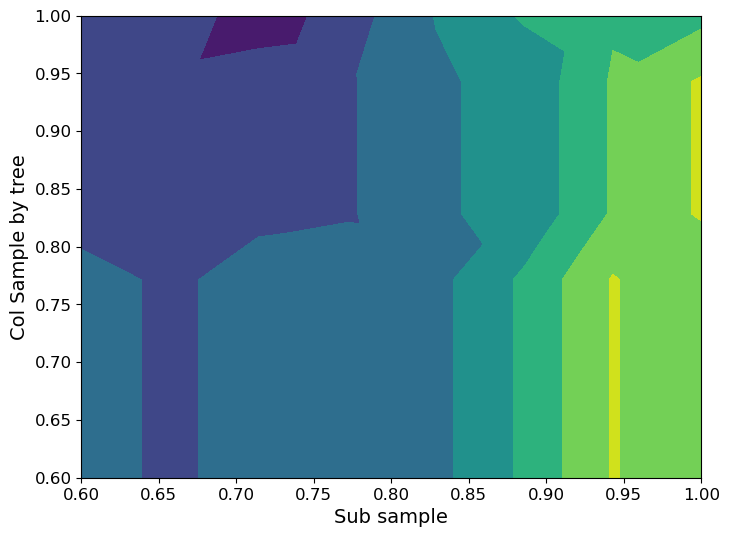

In [16]:
r = report(mtm)

res = r.plotting

ss = res.parameter_values[:, 1]
cbt = res.parameter_values[:, 2]

figure(figsize=(8,6))
tricontourf(ss, cbt, res.measurements)

xlabel("Sub sample", fontsize = 14)
ylabel("Col Sample by tree", fontsize = 14)
xticks(fontsize = 12)
yticks(fontsize = 12)
savefig("./plots/4.4.2.png")

Let's retrieve the best models:

In [17]:
xgb = fitted_params(mtm).best_model
@show xgb.subsample
@show xgb.colsample_bytree

xgb.subsample = 0.7142857142857143
xgb.colsample_bytree = 1.0


1.0

We could continue with more fine tuning but given how small the dataset is, it doesn't make much sense. How does it fare on the test set?

In [18]:
ŷ = predict_mode(mtm, rows = test)
round(accuracy(ŷ, y[test]), sigdigits = 3)

0.9